# Assignment

In this assignment, we cover an example of a non-tree-based classifier. Tree-based classifiers are so common that they have their own functions in `sklearn`, but if we want we can choose any base-learners and pass it to the `BaggingClassifier` or any of the other ensemble learners in `sklearn.ensemble`. In the following example, we use `KNeighborsClassifier` as the base learner and train a bagged classifier.

In [1]:
!pip install category_encoders

     |████████████████████████████████| 80 kB 4.6 MB/s             


In [1]:
import pandas as pd
import numpy as np
import category_encoders as ce
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import warnings
warnings.filterwarnings("ignore")


Let's load the titanic data set for this assignment. The data consists of categorical features such as `sex`and `embark`.  There are ordinal features that might be numeric such as `pclass`, `sibsp`, and `parch`.  There are numeric features such as `fare` and `age`.   There are features that should be unique or almost unique per row such as `passengerid`, `name`, `cabin` and `ticket`.

In [3]:
titanic = pd.read_csv('titanic.csv', sep = ',', header = 0)
titanic.columns = titanic.columns.str.lower() # use all lower case column names
titanic.head()

,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
titanic_2 = titanic.drop(columns=['passengerid', 'cabin', 'ticket', 'name'])
titanic_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   survived  891 non-null    int64  
 1   pclass    891 non-null    int64  
 2   sex       891 non-null    object 
 3   age       714 non-null    float64
 4   sibsp     891 non-null    int64  
 5   parch     891 non-null    int64  
 6   fare      891 non-null    float64
 7   embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 55.8+ KB


- Split the data into training and testing and perform the necessary pre-processing steps to get the data ready for modeling. We will not list all the steps here as you should be familiar with them. <span style="color:red" float:right>[5 point]</span>

In [5]:
titanic_3 = titanic_2.dropna(subset=['embarked'])
titanic_3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   survived  889 non-null    int64  
 1   pclass    889 non-null    int64  
 2   sex       889 non-null    object 
 3   age       712 non-null    float64
 4   sibsp     889 non-null    int64  
 5   parch     889 non-null    int64  
 6   fare      889 non-null    float64
 7   embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 62.5+ KB


In [6]:
mean_v = titanic_3['age'].mean()
titanic_3['age'].fillna(value=mean_v, inplace=True)
titanic_3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   survived  889 non-null    int64  
 1   pclass    889 non-null    int64  
 2   sex       889 non-null    object 
 3   age       889 non-null    float64
 4   sibsp     889 non-null    int64  
 5   parch     889 non-null    int64  
 6   fare      889 non-null    float64
 7   embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 62.5+ KB


In [7]:
titanic_3.describe()

,survived,pclass,age,sibsp,parch,fare
count,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000
mean,0.382452,2.311586,29.642093,0.524184,0.382452,32.096681
std,0.486260,0.834700,12.968346,1.103705,0.806761,49.697504
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,22.000000,0.000000,0.000000,7.895800
50%,0.000000,3.000000,29.642093,0.000000,0.000000,14.454200
75%,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [8]:
titanic_3['fare']=titanic_3['fare'] / titanic_3['fare'].abs().max()
titanic_3['age']=titanic_3['age'] / titanic_3['age'].abs().max()
titanic_3.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked
0,0,3,male,0.2750,1,0,0.014151,S
1,1,1,female,0.4750,1,0,0.139136,C
2,1,3,female,0.3250,0,0,0.015469,S
3,1,1,female,0.4375,1,0,0.103644,S
4,0,3,male,0.4375,0,0,0.015713,S


In [9]:
titanic_3.describe()

,survived,pclass,age,sibsp,parch,fare
count,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000
mean,0.382452,2.311586,0.370526,0.524184,0.382452,0.062649
std,0.486260,0.834700,0.162104,1.103705,0.806761,0.097003
min,0.000000,1.000000,0.005250,0.000000,0.000000,0.000000
25%,0.000000,2.000000,0.275000,0.000000,0.000000,0.015412
50%,0.000000,3.000000,0.370526,0.000000,0.000000,0.028213
75%,1.000000,3.000000,0.437500,1.000000,0.000000,0.060508
max,1.000000,3.000000,1.000000,8.000000,6.000000,1.000000


- Come back here to label encode sex, not OHE

le = LabelEncoder()
x['sex'] = le.fit_transform(x['sex'])
x['embarked'] = le.fit_transform(x['embarked'])
x.head()

In [8]:
titanic_3_encoded = pd.get_dummies(titanic_3, columns = ['sex', 'embarked'])
titanic_3_encoded.head()

,survived,pclass,age,sibsp,parch,fare,sex_female,sex_male,embarked_C,embarked_Q,embarked_S
0,0,3,0.2750,1,0,0.014151,0,1,0,0,1
1,1,1,0.4750,1,0,0.139136,1,0,1,0,0
2,1,3,0.3250,0,0,0.015469,1,0,0,0,1
3,1,1,0.4375,1,0,0.103644,1,0,0,0,1
4,0,3,0.4375,0,0,0.015713,0,1,0,0,1


- Potential Class Imbalance Issues?

In [9]:
titanic_3.sex.value_counts()

male      577
female    312
Name: sex, dtype: int64

- Potential to OHE both sibsp and parch???

In [10]:
titanic_3.sibsp.value_counts()

0    606
1    209
2     28
4     18
3     16
8      7
5      5
Name: sibsp, dtype: int64

In [11]:
titanic_3.parch.value_counts()

0    676
1    118
2     80
5      5
3      5
4      4
6      1
Name: parch, dtype: int64

In [12]:
titanic_4_encoded = pd.get_dummies(titanic_3, columns = ['sex', 'embarked', 'sibsp', 'parch'])
titanic_4_encoded.head()

,survived,pclass,age,fare,sex_female,sex_male,embarked_C,embarked_Q,embarked_S,sibsp_0,...,sibsp_4,sibsp_5,sibsp_8,parch_0,parch_1,parch_2,parch_3,parch_4,parch_5,parch_6
0,0,3,0.2750,0.014151,0,1,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
1,1,1,0.4750,0.139136,1,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,1,3,0.3250,0.015469,1,0,0,0,1,1,...,0,0,0,1,0,0,0,0,0,0
3,1,1,0.4375,0.103644,1,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
4,0,3,0.4375,0.015713,0,1,0,0,1,1,...,0,0,0,1,0,0,0,0,0,0


In [13]:
titanic_5_encoded = titanic_4_encoded.drop(columns=['embarked_C', 'embarked_Q', 'embarked_S'])
titanic_5_encoded.head()

,survived,pclass,age,fare,sex_female,sex_male,sibsp_0,sibsp_1,sibsp_2,sibsp_3,sibsp_4,sibsp_5,sibsp_8,parch_0,parch_1,parch_2,parch_3,parch_4,parch_5,parch_6
0,0,3,0.2750,0.014151,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0
1,1,1,0.4750,0.139136,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0
2,1,3,0.3250,0.015469,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
3,1,1,0.4375,0.103644,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0
4,0,3,0.4375,0.015713,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0


In [14]:
x = titanic_3_encoded.drop('survived', axis=1).copy()
y = titanic_3_encoded['survived'].copy()
print(x.head())
print(y.head())

   pclass     age  sibsp  parch      fare  sex_female  sex_male  embarked_C  \
0       3  0.2750      1      0  0.014151           0         1           0   
1       1  0.4750      1      0  0.139136           1         0           1   
2       3  0.3250      0      0  0.015469           1         0           0   
3       1  0.4375      1      0  0.103644           1         0           0   
4       3  0.4375      0      0  0.015713           0         1           0   

   embarked_Q  embarked_S  
0           0           1  
1           0           0  
2           0           1  
3           0           1  
4           0           1  
0    0
1    1
2    1
3    1
4    0
Name: survived, dtype: int64


In [15]:
x_encoded = titanic_4_encoded.drop('survived', axis=1).copy()
y_encoded = titanic_4_encoded['survived'].copy()
print(x_encoded.head())
print(y_encoded.head())

   pclass     age      fare  sex_female  sex_male  embarked_C  embarked_Q  \
0       3  0.2750  0.014151           0         1           0           0   
1       1  0.4750  0.139136           1         0           1           0   
2       3  0.3250  0.015469           1         0           0           0   
3       1  0.4375  0.103644           1         0           0           0   
4       3  0.4375  0.015713           0         1           0           0   

   embarked_S  sibsp_0  sibsp_1  ...  sibsp_4  sibsp_5  sibsp_8  parch_0  \
0           1        0        1  ...        0        0        0        1   
1           0        0        1  ...        0        0        0        1   
2           1        1        0  ...        0        0        0        1   
3           1        0        1  ...        0        0        0        1   
4           1        1        0  ...        0        0        0        1   

   parch_1  parch_2  parch_3  parch_4  parch_5  parch_6  
0        0        0   

In [16]:
x_port = titanic_5_encoded.drop('survived', axis=1).copy()
y_port = titanic_5_encoded['survived'].copy()
print(x_port.head())
print(y_port.head())

   pclass     age      fare  sex_female  sex_male  sibsp_0  sibsp_1  sibsp_2  \
0       3  0.2750  0.014151           0         1        0        1        0   
1       1  0.4750  0.139136           1         0        0        1        0   
2       3  0.3250  0.015469           1         0        1        0        0   
3       1  0.4375  0.103644           1         0        0        1        0   
4       3  0.4375  0.015713           0         1        1        0        0   

   sibsp_3  sibsp_4  sibsp_5  sibsp_8  parch_0  parch_1  parch_2  parch_3  \
0        0        0        0        0        1        0        0        0   
1        0        0        0        0        1        0        0        0   
2        0        0        0        0        1        0        0        0   
3        0        0        0        0        1        0        0        0   
4        0        0        0        0        1        0        0        0   

   parch_4  parch_5  parch_6  
0        0        0      

In [17]:
X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=40, test_size=.3)
X_train_encoded, X_test_encoded, y_train_encoded, y_test_encoded = train_test_split(x_encoded, y_encoded, random_state=40, test_size=.3)
X_train_port, X_test_port, y_train_port, y_test_port = train_test_split(x_port, y_port, random_state = 40, test_size=.3)

- Train a KNN classifier using `KNeighborsClassifier` to predict how the features `pclass`, `sex`, `sibsp`, `parch`, `sex` and `fare` affect who survived the titanic shipwreck. <span style="color:red" float:right>[5 point]</span>

Notes and Scratch
- https://realpython.com/knn-python/
- https://medium.com/analytics-vidhya/titanic-machine-learning-by-k-nearest-neighbors-knn-algorithm-530d8bdd8323
- https://www.kaggle.com/code/solisrex/titanic-dataset-gradient-boosting-classifier/notebook
- https://www.kaggle.com/code/olanrewajurasheed/titanic-dataset-with-gradient-boosting/notebook
- https://github.com/Ankushr785/Kaggle-Titanic-Dataset/blob/master/Gradient%20Boosting%20Classifier.py


- I included embarked port as well due to the following evidence, looks like there is proof that individuals from port C had a higher survival rate, but in the last model I will remove them - 3 different accuracy metrics

1. OHE sex column but leaving parch and sibsp as is
2. OHE sex, parch and sibsp
3. model 2, but removed embarked


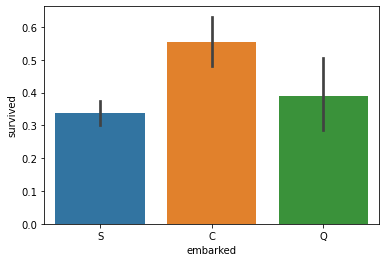

In [18]:
sns.barplot(data=titanic_2, x='embarked', y='survived');

In [19]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(622, 10)
(622,)
(267, 10)
(267,)


In [20]:
import sklearn.metrics as metrics

k_range = range(1,50)
scores=[]
for k in k_range:
    knn=KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    scores.append(metrics.accuracy_score(y_test, y_pred))
print(scores)

[0.7078651685393258, 0.7640449438202247, 0.7677902621722846, 0.7827715355805244, 0.7752808988764045, 0.7865168539325843, 0.7752808988764045, 0.7790262172284644, 0.7790262172284644, 0.7940074906367042, 0.7790262172284644, 0.7790262172284644, 0.7752808988764045, 0.7827715355805244, 0.7715355805243446, 0.7752808988764045, 0.7565543071161048, 0.7752808988764045, 0.7565543071161048, 0.7640449438202247, 0.7490636704119851, 0.7677902621722846, 0.7565543071161048, 0.7715355805243446, 0.7490636704119851, 0.7940074906367042, 0.7865168539325843, 0.7902621722846442, 0.7865168539325843, 0.7902621722846442, 0.7827715355805244, 0.7790262172284644, 0.7790262172284644, 0.7865168539325843, 0.7865168539325843, 0.7940074906367042, 0.7902621722846442, 0.7902621722846442, 0.7827715355805244, 0.7902621722846442, 0.7790262172284644, 0.7790262172284644, 0.7865168539325843, 0.7865168539325843, 0.7902621722846442, 0.7865168539325843, 0.7865168539325843, 0.7902621722846442, 0.7902621722846442]


In [21]:
import sklearn.metrics as metrics

k_range = range(1,50)
scores_encoded=[]
for k in k_range:
    knn=KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_encoded, y_train_encoded)
    y_pred_encoded = knn.predict(X_test_encoded)
    scores_encoded.append(metrics.accuracy_score(y_test_encoded, y_pred_encoded))
print(scores_encoded)

[0.7078651685393258, 0.7378277153558053, 0.7565543071161048, 0.7865168539325843, 0.7827715355805244, 0.7865168539325843, 0.7865168539325843, 0.7790262172284644, 0.7602996254681648, 0.7790262172284644, 0.7715355805243446, 0.7790262172284644, 0.7752808988764045, 0.7752808988764045, 0.7752808988764045, 0.7827715355805244, 0.7453183520599251, 0.7602996254681648, 0.7528089887640449, 0.7677902621722846, 0.7490636704119851, 0.7715355805243446, 0.7677902621722846, 0.7715355805243446, 0.7715355805243446, 0.8052434456928839, 0.8089887640449438, 0.8052434456928839, 0.8089887640449438, 0.8089887640449438, 0.797752808988764, 0.797752808988764, 0.7940074906367042, 0.797752808988764, 0.797752808988764, 0.7902621722846442, 0.7865168539325843, 0.7902621722846442, 0.7865168539325843, 0.7940074906367042, 0.7827715355805244, 0.7865168539325843, 0.7940074906367042, 0.7940074906367042, 0.7865168539325843, 0.7902621722846442, 0.7865168539325843, 0.7940074906367042, 0.7865168539325843]


In [22]:
import sklearn.metrics as metrics

k_range = range(1,50)
scores_port=[]
for k in k_range:
    knn=KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_port, y_train_port)
    y_pred_port = knn.predict(X_test_port)
    scores_port.append(metrics.accuracy_score(y_test_port, y_pred_port))
print(scores_port)

[0.7378277153558053, 0.7865168539325843, 0.7565543071161048, 0.7940074906367042, 0.7827715355805244, 0.8052434456928839, 0.7902621722846442, 0.8202247191011236, 0.797752808988764, 0.797752808988764, 0.7752808988764045, 0.8127340823970037, 0.7865168539325843, 0.8052434456928839, 0.7752808988764045, 0.8014981273408239, 0.7790262172284644, 0.7902621722846442, 0.7677902621722846, 0.7865168539325843, 0.7640449438202247, 0.7640449438202247, 0.7565543071161048, 0.7565543071161048, 0.7528089887640449, 0.7752808988764045, 0.7715355805243446, 0.7715355805243446, 0.7752808988764045, 0.7790262172284644, 0.7677902621722846, 0.7677902621722846, 0.7640449438202247, 0.7677902621722846, 0.7715355805243446, 0.8052434456928839, 0.7902621722846442, 0.8014981273408239, 0.7940074906367042, 0.8014981273408239, 0.797752808988764, 0.8089887640449438, 0.8014981273408239, 0.8127340823970037, 0.8052434456928839, 0.8089887640449438, 0.8089887640449438, 0.8089887640449438, 0.8014981273408239]


- Obtain predictions for the classifier predict on the training and test data, and get the accuracy score for the model. <span style="color:red" float:right>[2 point]</span>

Score for model 1 is: 0.7940074906367042


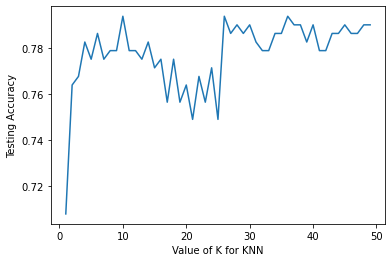

In [32]:
import matplotlib.pyplot as plt
plt.plot(k_range,scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Testing Accuracy')
print('Score for model 1 is:',max(scores))

Score for model 2 is: 0.8089887640449438


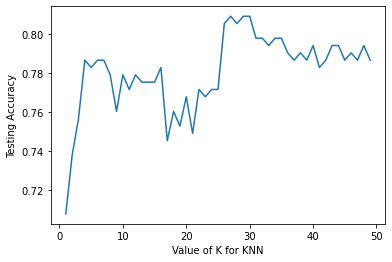

In [31]:
import matplotlib.pyplot as plt
plt.plot(k_range,scores_encoded)
plt.xlabel('Value of K for KNN')
plt.ylabel('Testing Accuracy')
print('Score for model 2 is:', max(scores_encoded))

Score for model 3 is: 0.8202247191011236


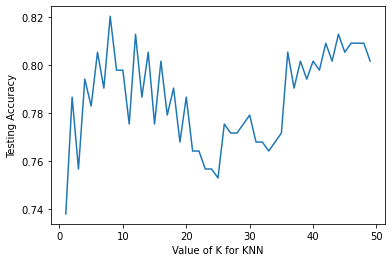

In [34]:
import matplotlib.pyplot as plt
plt.plot(k_range,scores_port)
plt.xlabel('Value of K for KNN')
plt.ylabel('Testing Accuracy')
print('Score for model 3 is:',max(scores_port))

- Use `BaggingClassifier` to train an ensemble model of `KNeighborsClassifier` base classifiers. Each base classifier should be trained only on a sample half the size of the training data, and using only half as many features as there are in in total the training data (read the documentation for the function to see how to do this). <span style="color:red" float:right>[5 point]</span>

Notes and Scratch
- https://stackabuse.com/gradient-boosting-classifiers-in-python-with-scikit-learn/
- https://bradzzz.gitbooks.io/ga-seattle-dsi/content/dsi/dsi_06_trees_methods/2.3-lesson/readme.html
- https://www.kaggle.com/code/masumrumi/bagging-with-titanic-dataset/notebook

In [35]:
from sklearn.ensemble import RandomForestClassifier

hypers_1 = {"n_estimators": 500, "max_features": "sqrt", "max_depth": 20, "min_samples_leaf": 10}

clf_rf_1 = RandomForestClassifier(random_state = 0, verbose = True, **hypers_1)


In [36]:
clf_rf_1.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.6s finished


RandomForestClassifier(max_depth=20, max_features='sqrt', min_samples_leaf=10,
                       n_estimators=500, random_state=0, verbose=True)

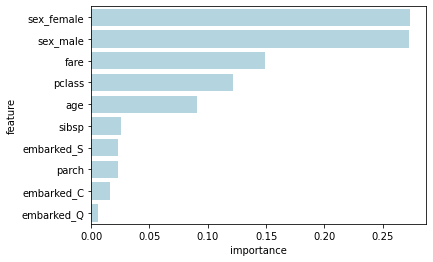

In [37]:
df_var_imp = pd.DataFrame({"feature": X_train.columns, 
                           "importance": clf_rf_1.feature_importances_})
df_var_imp.sort_values(by = "importance", ascending = False, inplace = True)

ax = sns.barplot(x = "importance", y = "feature", data = df_var_imp.head(10), color = "lightblue")

In [38]:
clf_rf_1.fit(X_train_encoded, y_train_encoded)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.5s finished


RandomForestClassifier(max_depth=20, max_features='sqrt', min_samples_leaf=10,
                       n_estimators=500, random_state=0, verbose=True)

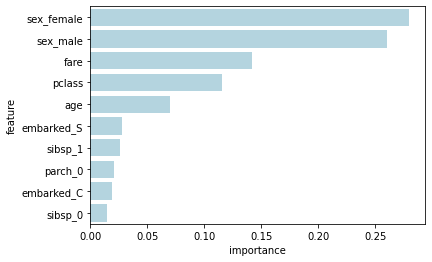

In [39]:
df_var_imp_encoded = pd.DataFrame({"feature": X_train_encoded.columns, 
                           "importance": clf_rf_1.feature_importances_})
df_var_imp_encoded.sort_values(by = "importance", ascending = False, inplace = True)

ax = sns.barplot(x = "importance", y = "feature", data = df_var_imp_encoded.head(10), color = "lightblue")

In [40]:
clf_rf_1.fit(X_train_port, y_train_port)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.5s finished


RandomForestClassifier(max_depth=20, max_features='sqrt', min_samples_leaf=10,
                       n_estimators=500, random_state=0, verbose=True)

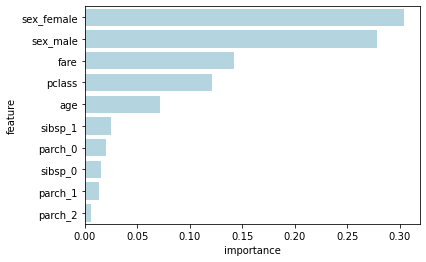

In [41]:
df_var_imp_port = pd.DataFrame({"feature": X_train_port.columns, 
                           "importance": clf_rf_1.feature_importances_})
df_var_imp_port.sort_values(by = "importance", ascending = False, inplace = True)

ax = sns.barplot(x = "importance", y = "feature", data = df_var_imp_port.head(10), color = "lightblue")

In [42]:
features = round(len(X_train.columns)/2)
clf_bc = BaggingClassifier(base_estimator = KNeighborsClassifier(n_neighbors=10), n_estimators=20, 
                           max_samples = len(X_train*0.5), max_features = features, random_state=40)

In [43]:
clf_bc.fit(X_train, y_train)

BaggingClassifier(base_estimator=KNeighborsClassifier(n_neighbors=10),
                  max_features=5, max_samples=622, n_estimators=20,
                  random_state=40)

In [44]:
features_enc=round(len(X_train_encoded.columns)/2)
clf_bc_enc = BaggingClassifier(base_estimator = KNeighborsClassifier(n_neighbors=10), n_estimators=20, 
                           max_samples = len(X_train_encoded*0.5), max_features = features_enc, random_state=40)

In [45]:
clf_bc_enc.fit(X_train_encoded, y_train_encoded)

BaggingClassifier(base_estimator=KNeighborsClassifier(n_neighbors=10),
                  max_features=11, max_samples=622, n_estimators=20,
                  random_state=40)

In [46]:
features_port=round(len(X_train_port.columns)/2)
clf_bc_port = BaggingClassifier(base_estimator = KNeighborsClassifier(n_neighbors=10), n_estimators=20, 
                           max_samples = len(X_train_port*0.5), max_features = features_port, random_state=40)

In [47]:
clf_bc_port.fit(X_train_port, y_train_port)

BaggingClassifier(base_estimator=KNeighborsClassifier(n_neighbors=10),
                  max_features=10, max_samples=622, n_estimators=20,
                  random_state=40)

- Obtain the accuracy and write down your conclusion. Did using an ensemble model improve the performance on the test data? <span style="color:red" float:right>[3 point]</span>

In [48]:
#Model 1 - OHE sex, did nto OHE parch, sibsp; embarked is intact
print('Model test Score: %.3f, ' %clf_bc.score(X_test, y_test),
      'Model training Score: %.3f' %clf_bc.score(X_train, y_train))

Model test Score: 0.809,  Model training Score: 0.847


In [50]:
#Model 2 - OHE sex, parch, sibsp; embarked is intact
print('Model test Score: %.3f, ' %clf_bc_enc.score(X_test_encoded, y_test_encoded),
      'Model training Score: %.3f' %clf_bc_enc.score(X_train_encoded, y_train_encoded))

Model test Score: 0.809,  Model training Score: 0.826


In [51]:
#Model 3 - OHE sex, parch, sibsp; embarked is removed
print('Model test Score: %.3f, ' %clf_bc_port.score(X_test_port, y_test_port),
      'Model training Score: %.3f' %clf_bc_port.score(X_train_port, y_train_port))

Model test Score: 0.801,  Model training Score: 0.847


- It looks like the basic ensemble models from above did little to improve the accuracy - will look into more below

- One potential thing to improve would be to change that I OHE sex - it is binary so it can be somewhat silly to do that - would want to LE that instead of OHE

# End of assignment

- Further Steps I would like to explore - hyperparameters of model - how n_estimator, neighbors, etc... can affect the model

In [52]:
clf_bc_test_1 = BaggingClassifier(base_estimator = KNeighborsClassifier(n_neighbors=4), n_estimators=10, 
                           max_samples = len(X_train*0.5), max_features = features, random_state=40)

clf_bc_test_1.fit(X_train, y_train)

print('Model test Score: %.3f, ' %clf_bc_test_1.score(X_test, y_test),
      'Model training Score: %.3f' %clf_bc_test_1.score(X_train, y_train))

Model test Score: 0.805,  Model training Score: 0.879


In [53]:
clf_bc_test_2 = BaggingClassifier(base_estimator = KNeighborsClassifier(n_neighbors=6), n_estimators=15, 
                           max_samples = len(X_train*0.5), max_features = features, random_state=40)

clf_bc_test_2.fit(X_train, y_train)

print('Model test Score: %.3f, ' %clf_bc_test_2.score(X_test, y_test),
      'Model training Score: %.3f' %clf_bc_test_2.score(X_train, y_train))


Model test Score: 0.813,  Model training Score: 0.862


In [54]:
clf_bc_test_3 = BaggingClassifier(base_estimator = KNeighborsClassifier(n_neighbors=7), n_estimators=20, 
                           max_samples = len(X_train*0.5), max_features = features, random_state=40)

clf_bc_test_3.fit(X_train, y_train)

print('Model test Score: %.3f, ' %clf_bc_test_3.score(X_test, y_test),
      'Model training Score: %.3f' %clf_bc_test_3.score(X_train, y_train))

Model test Score: 0.824,  Model training Score: 0.852


In [55]:
clf_bc_test_4 = BaggingClassifier(base_estimator = KNeighborsClassifier(n_neighbors=8), n_estimators=15, 
                           max_samples = len(X_train*0.5), max_features = features, random_state=40)

clf_bc_test_4.fit(X_train, y_train)

print('Model test Score: %.3f, ' %clf_bc_test_4.score(X_test, y_test),
      'Model training Score: %.3f' %clf_bc_test_4.score(X_train, y_train))

Model test Score: 0.820,  Model training Score: 0.846


- Will now test the optimal model on the other datasets (port, embarked)

In [56]:
clf_bc_test_3_encoded = BaggingClassifier(base_estimator = KNeighborsClassifier(n_neighbors=7), n_estimators=20, 
                           max_samples = len(X_train_encoded*0.5), max_features = features_enc, random_state=40)

clf_bc_test_3_encoded.fit(X_train_encoded, y_train_encoded)

print('Model test Score: %.3f, ' %clf_bc_test_3_encoded.score(X_test_encoded, y_test_encoded),
      'Model training Score: %.3f' %clf_bc_test_3_encoded.score(X_train_encoded, y_train_encoded))

Model test Score: 0.813,  Model training Score: 0.854


In [57]:
clf_bc_test_3_port = BaggingClassifier(base_estimator = KNeighborsClassifier(n_neighbors=7), n_estimators=20, 
                           max_samples = len(X_train_port*0.5), max_features = features_port, random_state=40)

clf_bc_test_3_port.fit(X_train_port, y_train_port)

print('Model test Score: %.3f, ' %clf_bc_test_3_port.score(X_test_port, y_test_port),
      'Model training Score: %.3f' %clf_bc_test_3_port.score(X_train_port, y_train_port))

Model test Score: 0.798,  Model training Score: 0.849
